c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


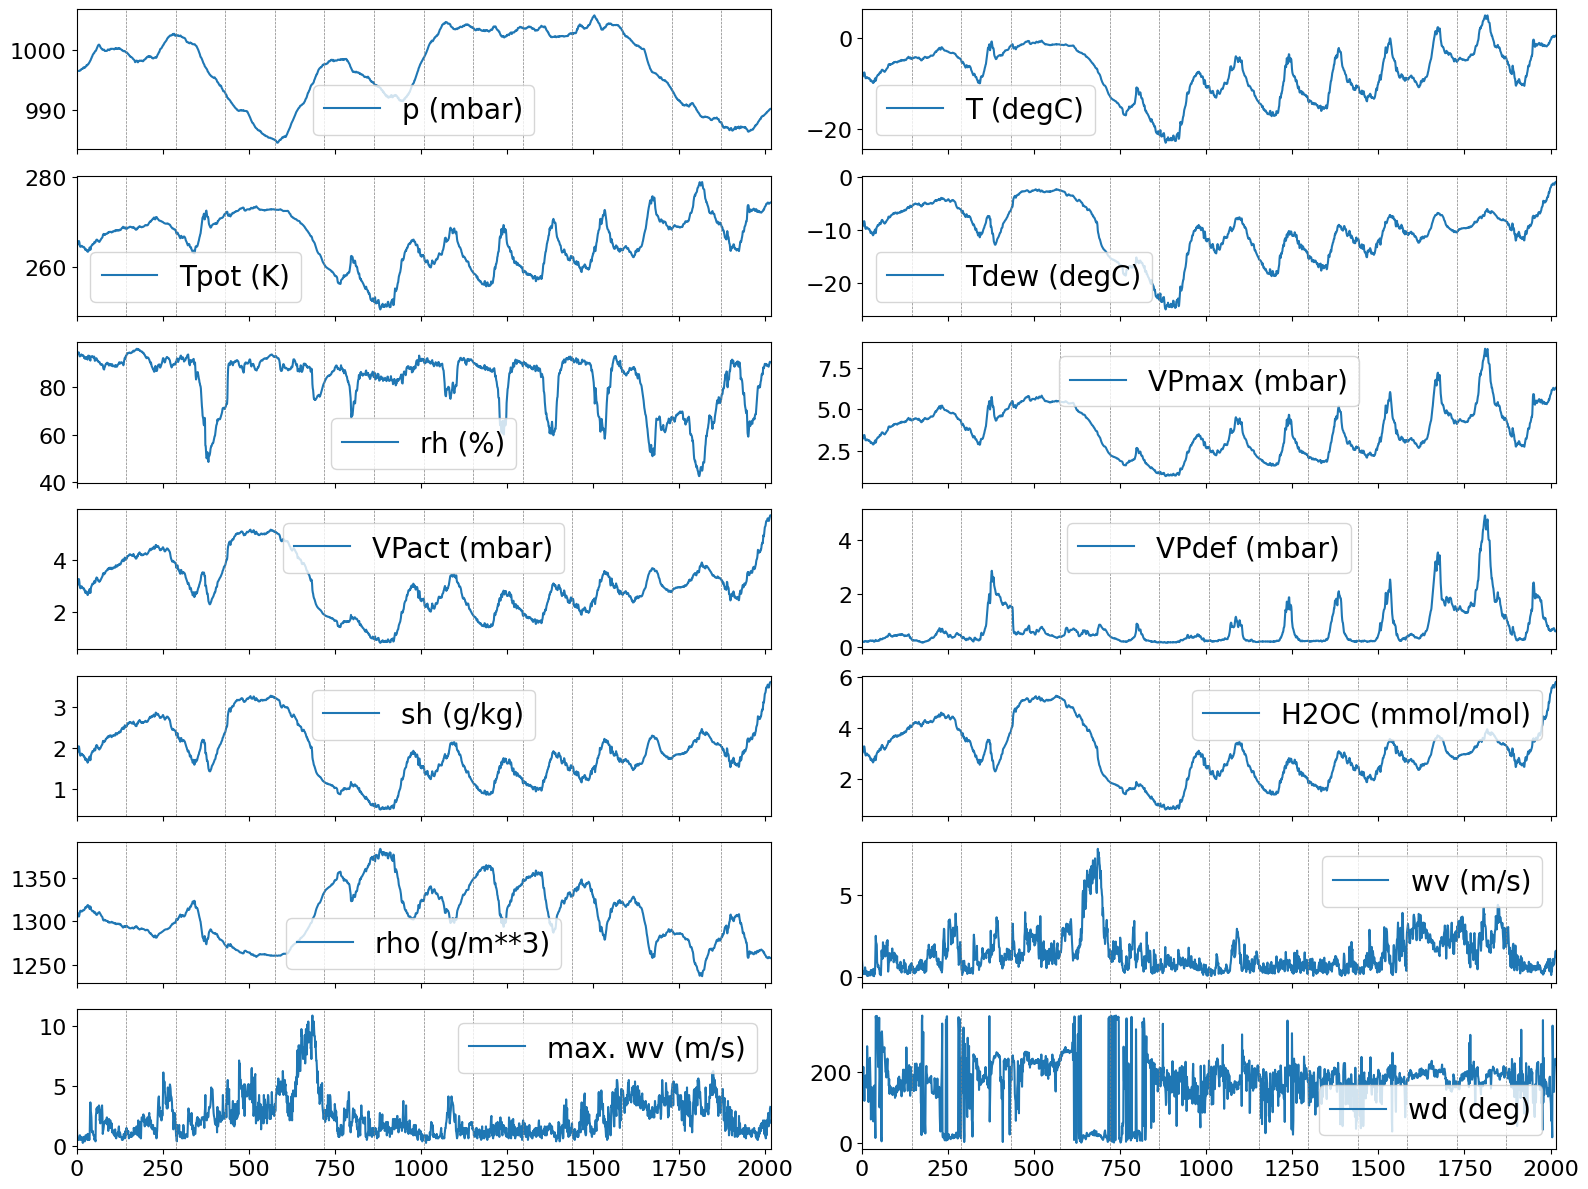

In [ ]:
#%%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import deeptrack as dt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import deeplay as dl
from matplotlib.ticker import FixedLocator
from torch_geometric.nn.norm import LayerNorm
from torch_geometric.data import Data


dataframe = pd.read_csv("jena_climate_2009_2016.csv", index_col=0)
data = dataframe.values
header = dataframe.columns.tolist()

start, days, daily_samples = 0, 14, 144
end = start + daily_samples * days

fig, axs = plt.subplots(7, 2, figsize=(16, 12), sharex=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(np.arange(start, end), data[start:end, i], label=header[i])
    ax.set_xlim(start, end)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.legend(fontsize=20)

    for day in range(1, days):
        ax.axvline(x=start + daily_samples * day,
                   color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

n_samples, n_features = data.shape[0], data.shape[1]
past_seq = 2 * daily_samples
lag = 72
temp_idx = 1  # Temperature (Celsius) index.

in_sequences, targets = [], []
for i in range(past_seq, n_samples - lag, daily_samples):
    in_sequences.append(data[i - past_seq:i, :])
    targets.append(data[i + lag:i + lag + 1, temp_idx])
in_sequences, targets = np.asarray(in_sequences), np.asarray(targets)

sources = dt.sources.Source(inputs=in_sequences, targets=targets)
train_sources, val_sources = dt.sources.random_split(sources, [0.8, 0.2])

train_mean = np.mean([src["inputs"] for src in train_sources], axis=(0, 1))
train_std = np.std([src["inputs"] for src in train_sources], axis=(0, 1))

inputs_pipeline = (dt.Value(sources.inputs - train_mean) / train_std
                   >> dt.pytorch.ToTensor(dtype=torch.float))
targets_pipeline = (dt.Value(sources.targets - train_mean[temp_idx]) 
                    / train_std[temp_idx])

train_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                   inputs=train_sources)
val_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                 inputs=val_sources)

def collate(batch_of_sequences):
    sequences, labels, batch_indices = [], [], []
    for batch_index, (sequence, label) in enumerate(batch_of_sequences):
        sequences.append(sequence)
        batch_indices.append(torch.ones(sequence.shape[0], dtype=torch.long) * batch_index)
        labels.append(label)
    return Data(sequences=torch.cat(sequences),
                batch_indices=torch.cat(batch_indices),
                y=torch.stack(labels).float())

train_dataloader = \
    DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate)
val_dataloader = \
    DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate)

In [ ]:
#%% Functions

def add_periodic_encoding(X, d_model=16):
    batch_size, seq_len, _ = X.shape  # FIXED

    pe = np.zeros((seq_len, d_model))
    position = np.arange(seq_len).reshape(-1, 1)

    even_dim = np.arange(0, d_model, 2)
    odd_dim = np.arange(1, d_model, 2)

    pe[:, even_dim] = np.sin(position * np.exp(-np.log(10000.0) * even_dim / d_model))
    pe[:, odd_dim] = np.cos(position * np.exp(-np.log(10000.0) * odd_dim / d_model))

    pe = np.tile(pe[np.newaxis, :, :], (batch_size, 1, 1))

    return np.concatenate([X, pe], axis=-1)

class DotProductAttention(dl.DeeplayModule):
    """Dot-product attention."""
    def __init__(self):
        super().__init__()

    def forward(self, queries, keys, values, return_attn=False):
        attn_scores = torch.matmul(queries, keys.transpose(-2, -1)) / (keys.size(-1) ** 0.5)
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, values)
        if return_attn:
            return attn_output, attn_matrix
        return attn_output
    
class DotProductAttentionLayer(dl.DeeplayModule):
    """Single-head dot-product attention with linear projections."""

    def __init__(self, num_features):
        super().__init__()
        self.Wq = dl.Layer(torch.nn.Linear, num_features, num_features)
        self.Wk = dl.Layer(torch.nn.Linear, num_features, num_features)
        self.Wv = dl.Layer(torch.nn.Linear, num_features, num_features)
        self.Wout = dl.Layer(torch.nn.Linear, num_features, num_features)
        self.attn = DotProductAttention()

    def forward(self, in_sequence, batch_indices, return_attn=False):
        Q = self.Wq(in_sequence)
        K = self.Wk(in_sequence)
        V = self.Wv(in_sequence)

        mask = batch_indices.unsqueeze(1) == batch_indices.unsqueeze(0)

        attn_output, attn_matrix = self.attn(Q, K, V, return_attn=True)

        attn_output = self.Wout(attn_output)

        if return_attn:
            return attn_output, attn_matrix.masked_fill(~mask, 0)

        return attn_output

    
class TransformerEncoderLayer(dl.DeeplayModule):
    def __init__(self, num_features, feedforward_dim, dropout=0.0):
        super().__init__()
        self.self_attn = DotProductAttentionLayer(num_features)
        self.attn_dropout = dl.Layer(torch.nn.Dropout, dropout)
        self.attn_skip = dl.Add()
        self.attn_norm = dl.Layer(LayerNorm, num_features, eps=1e-6)

        self.feedforward = dl.Sequential(
            dl.Layer(torch.nn.Linear, num_features, feedforward_dim),
            dl.Layer(torch.nn.ReLU),
            dl.Layer(torch.nn.Linear, feedforward_dim, num_features),
        )
        self.feedforward_dropout = dl.Layer(torch.nn.Dropout, dropout)
        self.feedforward_skip = dl.Add()
        self.feedforward_norm = dl.Layer(LayerNorm, num_features, eps=1e-6)

    def forward(self, in_sequence, batch_indices, return_attn=False):
        if return_attn:
            attns, attn_matrix = self.self_attn(in_sequence, batch_indices, return_attn=True)
        else:
            attns = self.self_attn(in_sequence, batch_indices)

        attns = self.attn_dropout(attns)
        attns = self.attn_skip(in_sequence, attns)
        attns = self.attn_norm(attns, batch_indices)

        out_sequence = self.feedforward(attns)
        out_sequence = self.feedforward_dropout(out_sequence)
        out_sequence = self.feedforward_skip(attns, out_sequence)
        out_sequence = self.feedforward_norm(out_sequence, batch_indices)

        if return_attn:
            return out_sequence, attn_matrix
        return out_sequence

    
class TransformerEncoderModel(dl.DeeplayModule):
    """Transformer encoder model."""

    def __init__(self, input_dim, num_features, num_heads, feedforward_dim,
                 num_layers, out_dim, dropout=0.0):
        """Initialize transformer encoder model."""
        super().__init__()
        self.num_features = num_features

        self.embedding = dl.Layer(torch.nn.Linear, input_dim, num_features)

        self.pos_encoder = dl.IndexedPositionalEmbedding(num_features)
        self.pos_encoder.dropout.configure(p=dropout)

        self.transformer_block = dl.LayerList()
        for _ in range(num_layers):
            self.transformer_block.append(TransformerEncoderLayer(
                    num_features, num_heads, feedforward_dim, dropout=dropout,
            ))

        self.out_block = dl.Sequential(
            dl.Layer(torch.nn.Dropout, dropout),
            dl.Layer(torch.nn.Linear, num_features, num_features // 2),
            dl.Layer(torch.nn.ReLU),
            dl.Layer(torch.nn.Linear, num_features // 2, out_dim),
            dl.Layer(torch.nn.Sigmoid),
        )

    def forward(self, dict):
        """Forward pass using custom periodic positional encoding (before embedding)."""
        in_sequence, batch_indices = dict["sequences"], dict["batch_indices"]

        batch_size = torch.max(batch_indices).item() + 1
        seq_len = (batch_indices == 0).sum().item()
        input_dim = in_sequence.shape[1]

        batch_input = torch.zeros(batch_size, seq_len, input_dim, device=in_sequence.device)
        for b in range(batch_size):
            batch_input[b] = in_sequence[batch_indices == b]

        pe_input = add_periodic_encoding(batch_input.cpu().numpy(), d_model=16) 
        pe_input = torch.tensor(pe_input, dtype=torch.float32, device=in_sequence.device)

        pe_input_flat = pe_input.view(-1, pe_input.shape[-1])

        embeddings = self.embedding(pe_input_flat) * self.num_features ** 0.5

        out_sequence = embeddings
        for transformer_layer in self.transformer_block:
            out_sequence = transformer_layer(out_sequence, batch_indices)

        aggregates = torch.zeros(batch_size, out_sequence.shape[-1], device=out_sequence.device)
        for b in range(batch_size):
            aggregates[b] = out_sequence[batch_indices == b].mean(dim=0)

        pred = self.out_block(aggregates).squeeze()
        return pred

def plot_attention(query_tokens, key_tokens, attn_matrix, step=10):
    """Plot attention with fewer axis labels."""
    fig, ax = plt.subplots(figsize=(8, 8))
    cax = ax.matshow(attn_matrix, cmap="Greens")
    fig.colorbar(cax)

    xticks = list(range(0, len(key_tokens), step))
    yticks = list(range(0, len(query_tokens), step))

    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    ax.set_xticklabels([key_tokens[i] for i in xticks], rotation=90)
    ax.set_yticklabels([query_tokens[i] for i in yticks])

    ax.set_xlabel("Key", fontsize=12)
    ax.set_ylabel("Query", fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
#%% Train

epochs = 5

model = TransformerEncoderModel(
    num_features=300,
    num_heads=1,
    feedforward_dim=512,
    num_layers=4,
    out_dim=1,
    dropout=0.1,
    input_dim=n_features + 16
).create()


regressor = dl.Regressor(model, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="gpu")
trainer.fit(regressor, train_dataloader, val_dataloader)

INFO: 
  | Name          | Type                    | Params | Mode 
------------------------------------------------------------------
0 | loss          | L1Loss                  | 0      | train
1 | train_metrics | MetricCollection        | 0      | train
2 | val_metrics   | MetricCollection        | 0      | train
3 | test_metrics  | MetricCollection        | 0      | train
4 | model         | TransformerEncoderModel | 3.0 M  | train
5 | optimizer     | Adam                    | 0      | train
------------------------------------------------------------------
1.5 M     Trainable params
1.5 M     Non-trainable params
3.0 M     Total params
12.031    Total estimated model params size (MB)
84        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                    | Params | Mode 
------------------------------------------------------------------
0 | loss          | L1Loss                  | 0      | train
1 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` i

Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

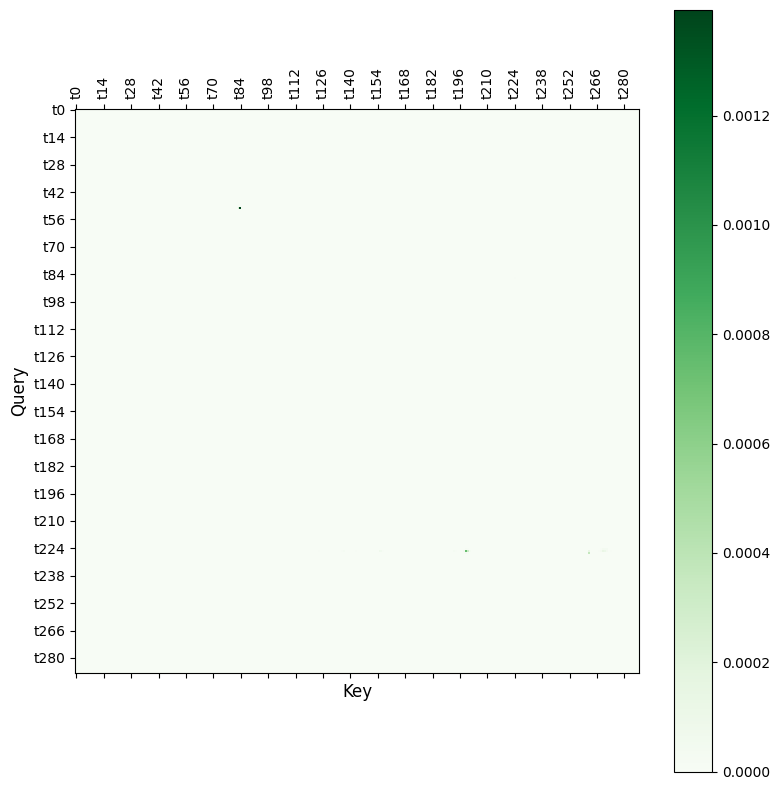

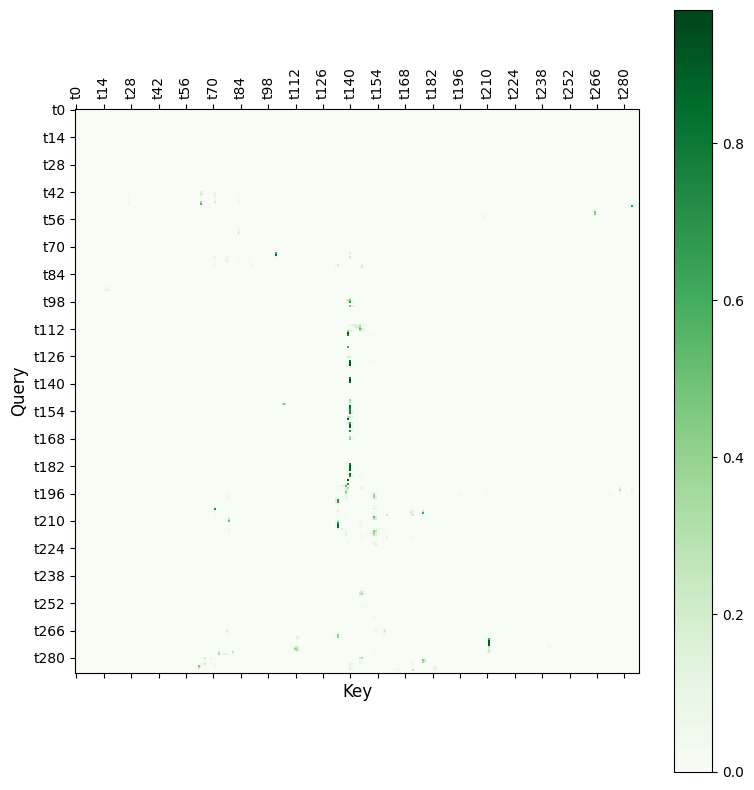

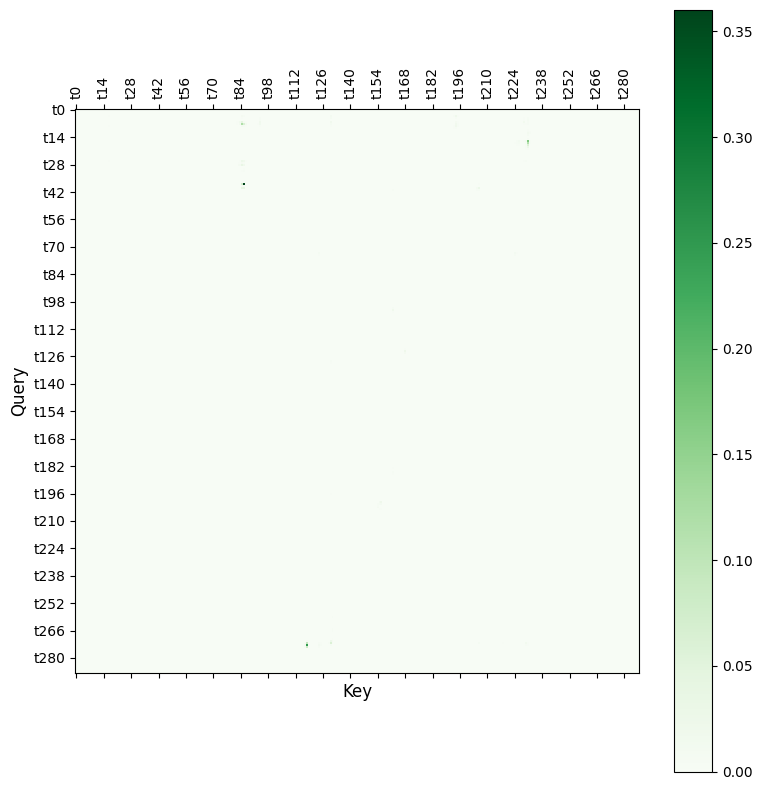

In [ ]:
#%%

batch = next(iter(val_dataloader))
sequences = batch["sequences"]             
batch_indices = batch["batch_indices"]     

with torch.no_grad():
    batch_size = torch.max(batch_indices).item() + 1
    seq_len = (batch_indices == 0).sum().item()
    input_dim = sequences.shape[1]

    batch_input = torch.zeros(batch_size, seq_len, input_dim, device=sequences.device)
    for b in range(batch_size):
        batch_input[b] = sequences[batch_indices == b]

    x_pe = add_periodic_encoding(batch_input.cpu().numpy(), d_model=16)
    x_pe = torch.tensor(x_pe, dtype=torch.float32, device=sequences.device)


    x_pe = x_pe.view(-1, x_pe.shape[-1])

    embeddings = model.embedding(x_pe) * model.num_features ** 0.5

    _, attn_matrix = model.transformer_block[0].self_attn(
        embeddings, batch_indices, return_attn=True
    )

selected_indices = [0, 3, 5]
for selected_index in selected_indices:
    mask = batch_indices == selected_index
    masked_indices = mask.nonzero(as_tuple=True)[0]

    attn_map = attn_matrix[masked_indices][:, masked_indices].cpu().numpy()
    tokens = [f"t{i}" for i in range(len(masked_indices))]

    plot_attention(tokens, tokens, attn_map, step=14)